# Coffea and Awkward

**March 15, 2023 at Beijing**

In [1]:
import awkward as ak
import uproot
import hist
import os
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods.base import NanoEventsArray
from imp import reload #每次修改调用函数后可以更新
import correctionlib, rich
import matplotlib.pyplot as plt
import sys

/tmp/ipykernel_71166/1593424902.py:8: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload #每次修改调用函数后可以更新


### coffea读文件

In [32]:
import input_file 
reload(input_file)
muonc_events = input_file.input_file('data')#5m
zg_events = input_file.input_file('zg')#7m
ttbar_events = input_file.input_file('tt')#8m
zz_events = input_file.input_file('zz')#8m
wz_events = input_file.input_file('wz')#8m
ww_events = input_file.input_file('ww')#9m

data  is done!
zg  is done!
tt  is done!
zz  is done!
wz  is done!
ww  is done!


In [33]:
EVENT = {
    'data':muonc_events,
    'zg': zg_events,
    'tt': ttbar_events,
    'zz': zz_events,
    'wz': wz_events,
    'ww': ww_events,
}

## selection

In [53]:
import selection_cut_test 
reload(selection_cut_test)
event_muon_phodrs = {key: {} for key in EVENT}

for key in EVENT.keys():
    event_muon_phodr = []
    event_variables = []
    for i in EVENT[key]:
#muon_cut
        if key != 'data':
            event_weight = {'event_weight':np.sign(i.Generator.weight)}
        else:
            event_weight =  {'event_weight':'NONE'}
        mu0 = selection_cut_test.muon(i,'num',True)
        mu1 = selection_cut_test.muon(mu0,'trigger','double')
        mu2,event2 = selection_cut_test.muon(mu1,'cutBasedID','tight')
        mu3 = selection_cut_test.muon(mu2,'pf','tight')
        mu4 = selection_cut_test.muon(mu3,'eta','2.4')
        mu5 = selection_cut_test.muon(mu4,'pt',event2)
        mu6 = selection_cut_test.muon(mu5,'pid',True)
        mass = selection_cut_test.MASS(mu6)
        mu_mass = selection_cut_test.muon(mu6,'mass',mass)
#photon_cut
        pho1 = selection_cut_test.photon(mu_mass, 'pt', '35')
        pho2 = selection_cut_test.photon(pho1, 'eta', '2.5')
        pho3 = selection_cut_test.photon(pho2, 'id', 'tight')
        if key == 'data':
            mass = selection_cut_test.MASS(pho3)
            event_variables.append(selection_cut_test.VARIABLES(pho3,mass,key,event_weight))
        else:
            pho4 = selection_cut_test.photon(pho3,'prompt',True)
            gen_photon = pho4.GenPart[(pho4.GenPart.pdgId==22) & pho4.GenPart.hasFlags(['isLastCopy',"isPrompt"])]
            photon4_near, photon4_gen_photon_dr = gen_photon.nearest(pho4.Photon, axis=1, return_metric=True)
            mask = ak.fill_none(photon4_gen_photon_dr < 0.3, True)
            pho5 = pho4[ak.num(pho4.Photon[ak.any(mask == True,axis=1)]) == 1]
            mass = selection_cut_test.MASS(pho5)
            event_variables.append(selection_cut_test.VARIABLES(pho5,mass,key,event_weight))
    event_muon_phodrs[key] = event_variables
    print(key,'event_muon_phodrs',event_muon_phodrs[key])

#data 6m  double 23m  
#zg 9m    double 32m
#tt 54m   double 108m
#zz 69m   double 108m  new 70m
#wz 105m  double 123m new 82m
#ww 119m  double 118m

data event_muon_phodrs [{'photon_pt': <Array [] type='0 * option[var * float32[parameters={"__doc__": "p_{T}"}]]'>, 'photon_eta': <Array [] type='0 * option[var * float32[parameters={"__doc__": "eta"}]]'>, 'muon1_pt': <Array [] type='0 * ?float32[parameters={"__doc__": "pt"}]'>, 'muon2_pt': <Array [] type='0 * ?float32[parameters={"__doc__": "pt"}]'>, 'muon1_eta': <Array [] type='0 * ?float32[parameters={"__doc__": "eta"}]'>, 'muon2_eta': <Array [] type='0 * ?float32[parameters={"__doc__": "eta"}]'>, 'muon_mass': <Array [] type='0 * ?float32'>, 'npvsGood': <Array [] type='0 * ?int32[parameters={"__doc__": "number of good reconstructed ...'>, 'Rho_Calo': <Array [] type='0 * ?float32[parameters={"__doc__": "rho from calo towers with |...'>, 'Rho_tracker': <Array [] type='0 * ?float32[parameters={"__doc__": "rho from charged PF Candida...'>}, {'photon_pt': <Array [[45.8], [39.9], [93.8], [62.4]] type='4 * option[var * float32[parameter...'>, 'photon_eta': <Array [[-2.41], [-1.06], [2.39],

In [54]:
# 样本名称列表
sample_names = ["data", "zg", "tt", "zz", "ww", "wz"]

# 初始化一个字典，用于存储合并后的数据
event_final = {}

# 遍历每个样本名称
for sample_name in sample_names:
    # 初始化一个字典，用于存储当前样本的合并数据
    event_final[sample_name] = {}

    # 获取第一个条目中的信息键
    info_keys = list(event_muon_phodrs[sample_name][0].keys())

    # 遍历每个信息键
    for info_key in info_keys:
        # 从 event_muon_phodrs 中提取当前样本和信息键的数据
        data_to_concatenate = [entry[info_key] for entry in event_muon_phodrs[sample_name]]

        # 使用 ak.concatenate 将数据连接在一起
        event_final[sample_name][info_key] = ak.concatenate(data_to_concatenate)

print(event_final)


{'data': {'photon_pt': <Array [[45.8], [39.9], ... [48], [39]] type='1419 * option[var * float32[parame...'>, 'photon_eta': <Array [[-2.41], [-1.06], ... [-2.09], [1.65]] type='1419 * option[var * float32...'>, 'muon1_pt': <Array [163, 54.4, 52.1, ... 49, 38.1, 71.7] type='1419 * ?float32[parameters={"...'>, 'muon2_pt': <Array [123, 42.7, 45.2, ... 36, 21.7, 34] type='1419 * ?float32[parameters={"__...'>, 'muon1_eta': <Array [-1.9, 0.42, 0.874, ... 2.29, -0.42] type='1419 * ?float32[parameters={"_...'>, 'muon2_eta': <Array [-1.44, 0.808, 1.96, ... 0.27, -0.151] type='1419 * ?float32[parameters={...'>, 'muon_mass': <Array [287, 90.8, 92.8, ... 83.8, 87.8, 89.3] type='1419 * ?float32'>, 'npvsGood': <Array [23, 32, 25, 19, 29, ... 15, 29, 26, 33] type='1419 * ?int32[parameters={...'>, 'Rho_Calo': <Array [8.72, 15.1, 8, ... 12.1, 10.5, 11.4] type='1419 * ?float32[parameters={"...'>, 'Rho_tracker': <Array [14.5, 21.5, 14.8, ... 15.3, 16.1, 18] type='1419 * ?float32[parameters={...'>}, 'zg':

In [55]:
event_final

{'data': {'photon_pt': <Array [[45.8], [39.9], ... [48], [39]] type='1419 * option[var * float32[parame...'>,
  'photon_eta': <Array [[-2.41], [-1.06], ... [-2.09], [1.65]] type='1419 * option[var * float32...'>,
  'muon1_pt': <Array [163, 54.4, 52.1, ... 49, 38.1, 71.7] type='1419 * ?float32[parameters={"...'>,
  'muon2_pt': <Array [123, 42.7, 45.2, ... 36, 21.7, 34] type='1419 * ?float32[parameters={"__...'>,
  'muon1_eta': <Array [-1.9, 0.42, 0.874, ... 2.29, -0.42] type='1419 * ?float32[parameters={"_...'>,
  'muon2_eta': <Array [-1.44, 0.808, 1.96, ... 0.27, -0.151] type='1419 * ?float32[parameters={...'>,
  'muon_mass': <Array [287, 90.8, 92.8, ... 83.8, 87.8, 89.3] type='1419 * ?float32'>,
  'npvsGood': <Array [23, 32, 25, 19, 29, ... 15, 29, 26, 33] type='1419 * ?int32[parameters={...'>,
  'Rho_Calo': <Array [8.72, 15.1, 8, ... 12.1, 10.5, 11.4] type='1419 * ?float32[parameters={"...'>,
  'Rho_tracker': <Array [14.5, 21.5, 14.8, ... 15.3, 16.1, 18] type='1419 * ?float32[paramet

## ABCD

In [56]:
# 读取 ROOT 文件并获取 TH2D
file_fake_photon_weight = uproot.open("/home/pku/muty/pku/ZGToLLG/run3_zg_analyzer_change/ZG_fakephoton_ABCD/testABCD_weight/fakephoton_weight.root")
hist_fake_photon_weight = file_fake_photon_weight["weight"]

# 将 TH2D 转换为 Awkward Array
fake_photon_weight_array = ak.Array(hist_fake_photon_weight.to_numpy()[0])

# 获取 photon_pt 和 photon_eta
photon_pt = event_final['data']['photon_pt'][:,0]
photon_eta = event_final['data']['photon_eta'][:,0]

# 限制 photon_pt 的最大值
photon_pt = ak.where(photon_pt > 100, 99.9, photon_pt)
#photon_eta = ak.where(photon_eta > 2.5, 2.49, ak.where(photon_eta < -2.5, -2.49, photon_eta))

# 获取 TH2D 的 bin 边缘
xedges = hist_fake_photon_weight.axis(0).edges()
yedges = hist_fake_photon_weight.axis(1).edges()

# 计算 photon_pt 和 photon_eta 的 bin 索引
x_bin_indices = np.digitize(photon_pt, xedges) - 1
y_bin_indices = np.digitize(photon_eta, yedges) - 1

# 使用 bin 索引从 fake_photon_weight_array 中获取权重
fake_photon_weights = fake_photon_weight_array[x_bin_indices, y_bin_indices]



In [57]:
dict_nonpromt = {'nonprompt':event_final['data']}
dict_nonpromt
event_final.update(dict_nonpromt)
event_final['nonprompt']

{'photon_pt': <Array [[45.8], [39.9], ... [48], [39]] type='1419 * option[var * float32[parame...'>,
 'photon_eta': <Array [[-2.41], [-1.06], ... [-2.09], [1.65]] type='1419 * option[var * float32...'>,
 'muon1_pt': <Array [163, 54.4, 52.1, ... 49, 38.1, 71.7] type='1419 * ?float32[parameters={"...'>,
 'muon2_pt': <Array [123, 42.7, 45.2, ... 36, 21.7, 34] type='1419 * ?float32[parameters={"__...'>,
 'muon1_eta': <Array [-1.9, 0.42, 0.874, ... 2.29, -0.42] type='1419 * ?float32[parameters={"_...'>,
 'muon2_eta': <Array [-1.44, 0.808, 1.96, ... 0.27, -0.151] type='1419 * ?float32[parameters={...'>,
 'muon_mass': <Array [287, 90.8, 92.8, ... 83.8, 87.8, 89.3] type='1419 * ?float32'>,
 'npvsGood': <Array [23, 32, 25, 19, 29, ... 15, 29, 26, 33] type='1419 * ?int32[parameters={...'>,
 'Rho_Calo': <Array [8.72, 15.1, 8, ... 12.1, 10.5, 11.4] type='1419 * ?float32[parameters={"...'>,
 'Rho_tracker': <Array [14.5, 21.5, 14.8, ... 15.3, 16.1, 18] type='1419 * ?float32[parameters={...'>}

## Pile-up 
(Rho_fixedGridRhoFastjetCentralCalo,GridRhoFastjetCentralChargedPileUp,PV_npvsGood)

In [48]:
# 1. 合并不同文件的数据
def concatenate_variables(sample, group, variable):
    print(sample)
    print(variable)
    sys.stdout.flush()  # 强制刷新输出缓冲区
    return ak.concatenate([sample[event_number][group] for event_number in range(len(sample))], axis=0)[variable]

variables = [
    ('Rho', 'fixedGridRhoFastjetCentralCalo'),
    ('Rho', 'fixedGridRhoFastjetCentralChargedPileUp'),
    ('PV', 'npvsGood')
]

combined_data = {variable: concatenate_variables(EVENT['data'], group, variable) for group, variable in variables}
combined_zz = {variable: concatenate_variables(EVENT['tt'], group, variable) for group, variable in variables}


[<NanoEventsArray [<event 356615:99:120277772>, ... ] type='142047 * event'>, <NanoEventsArray [<event 356563:23:2052411>, ... ] type='297788 * event'>, <NanoEventsArray [<event 356615:13:14663908>, ... ] type='318415 * event'>, <NanoEventsArray [<event 356615:163:200115061>, ... ] type='332483 * event'>, <NanoEventsArray [<event 356615:20:23535842>, ... ] type='328768 * event'>, <NanoEventsArray [<event 356615:2:1399574>, ... ] type='298096 * event'>, <NanoEventsArray [<event 356619:14:11223509>, ... ] type='324595 * event'>, <NanoEventsArray [<event 356719:102:83853745>, ... ] type='346702 * event'>, <NanoEventsArray [<event 356615:129:157616436>, ... ] type='329048 * event'>, <NanoEventsArray [<event 356615:1133:1272405841>, ... ] type='274418 * event'>, <NanoEventsArray [<event 356466:110:58218294>, ... ] type='480384 * event'>, <NanoEventsArray [<event 356619:69:55953339>, ... ] type='144017 * event'>, <NanoEventsArray [<event 356719:20:1746250>, ... ] type='379013 * event'>, <Nan

In [51]:
# 2. 画出归一化的三个变量的直方图
def plot_histogram(variable, data, zz, zz_weights=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})

    # 根据不同的变量设置合适的bins
    if variable == 'npvsGood':
        bins = np.arange(0, 66, 1)
    elif variable == 'GridRhoFastjetCentralChargedPileUp':
        bins = np.linspace(0, 60, 61)
    else:
        bins = np.linspace(0, 40, 41)

    # 主画布
    data_hist, data_edges = np.histogram(data[variable], bins=bins, density=True)
    zz_hist, zz_edges = np.histogram(zz[variable], bins=data_edges, density=True)

    if zz_weights is not None:
        zz_hist_weighted, _ = np.histogram(zz[variable], bins=data_edges, weights=zz_weights, density=True)
        ax1.hist(zz[variable], bins=bins, alpha=0.5, label='zz (weighted)', histtype='stepfilled', weights=zz_weights, density=True)

        # 更新第二个画布的Data/MC值
        ax2.scatter(data_edges[:-1], data_hist / zz_hist_weighted, color='green', label='Data/MC (weighted)', alpha=0.5)

    ax1.hist(zz[variable], bins=bins, alpha=0.5, label='zz', histtype='stepfilled', density=True)
    ax1.scatter(data_edges[:-1], data_hist, label='data', marker='o', color='red')
    ax1.legend()

    #ax1.set_xlabel(f"{variable} (unit)")
    ax1.set_ylabel("Normalized Counts")
    ax1.set_title(f"Normalized Histogram for {variable}")

    # 第二个画布
    ax2.scatter(data_edges[:-1], data_hist / zz_hist, color='blue', label='Data/MC', alpha=0.5)
    ax2.axhline(y=1, color='red', linewidth=0.5)
    ax2.set_ylim(0.5, 1.5)

    ax2.set_xlabel(f"{variable} (unit)")
    ax2.set_ylabel("Data/MC")
    ax2.legend()

    plt.show()


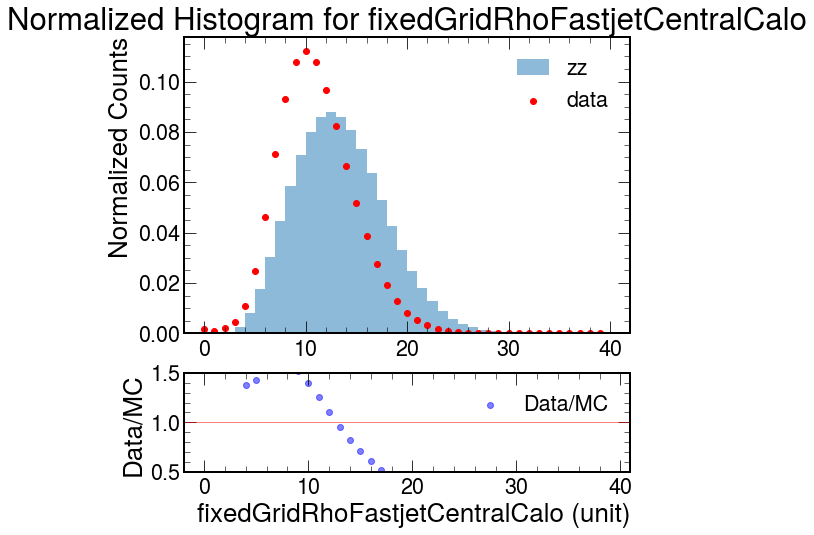

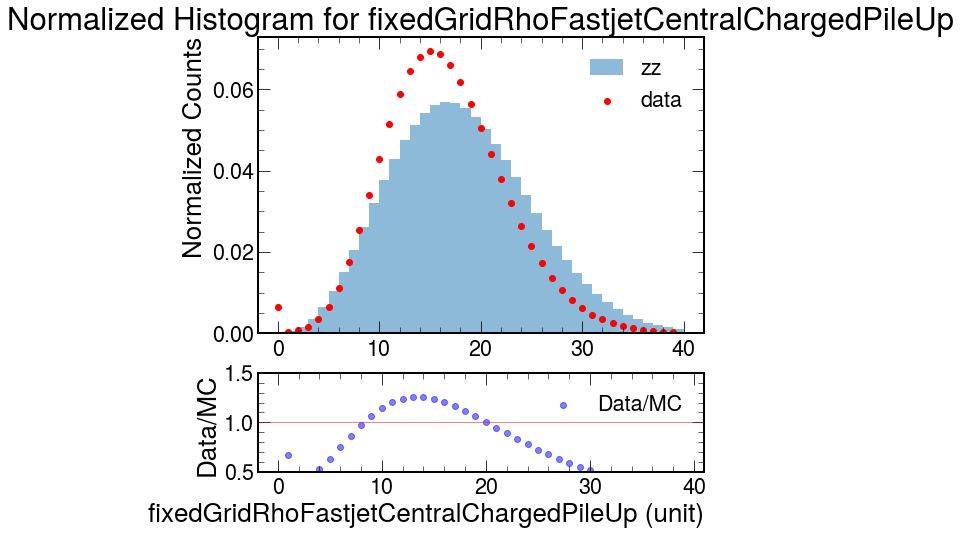

/tmp/ipykernel_71166/2432711612.py:33: RuntimeWarning: divide by zero encountered in true_divide
  ax2.scatter(data_edges[:-1], data_hist / zz_hist, color='blue', label='Data/MC', alpha=0.5)


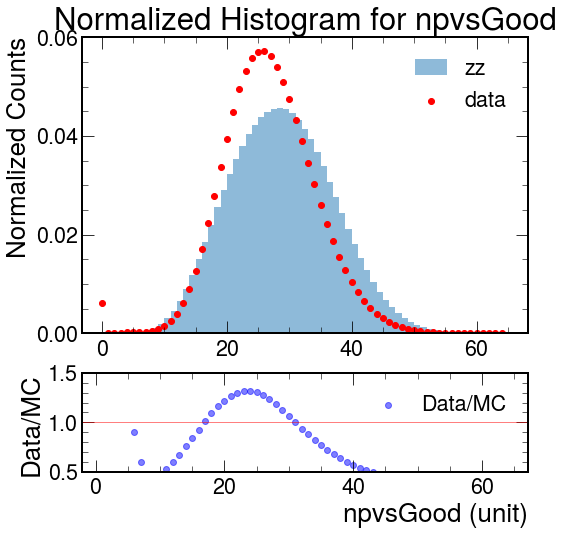

In [52]:
#无修正图
for group, variable in variables:
    plot_histogram(variable, combined_data, combined_zz)

/tmp/ipykernel_71166/521619427.py:12: RuntimeWarning: divide by zero encountered in true_divide
  data_mc_ratios[variable] = (data_edges[:-1], data_hist_normalized / zz_hist_normalized)
/tmp/ipykernel_71166/521619427.py:12: RuntimeWarning: invalid value encountered in true_divide
  data_mc_ratios[variable] = (data_edges[:-1], data_hist_normalized / zz_hist_normalized)


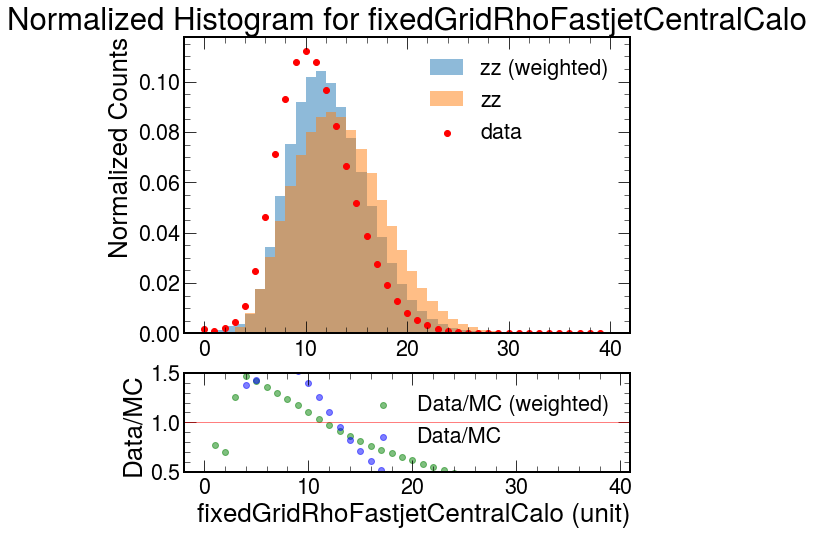

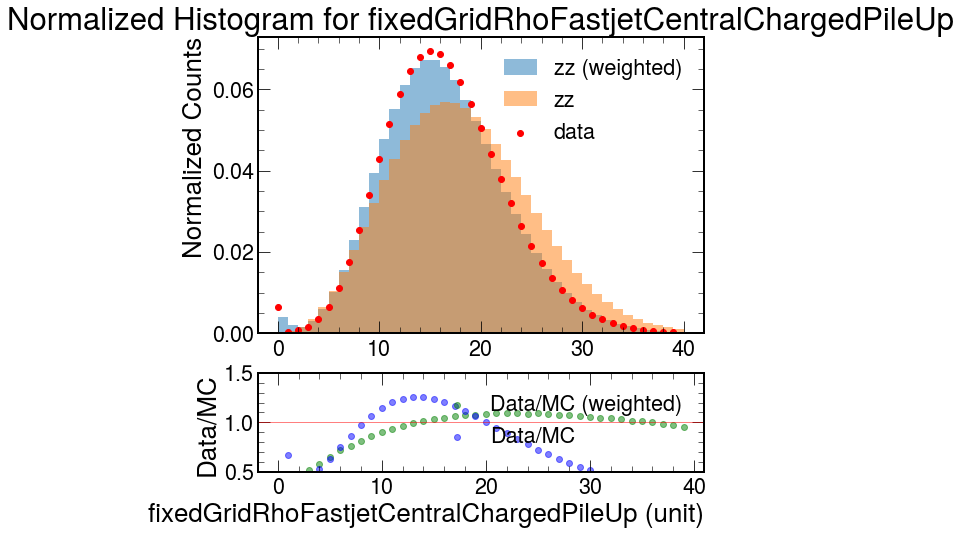

/tmp/ipykernel_71166/2432711612.py:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.scatter(data_edges[:-1], data_hist / zz_hist_weighted, color='green', label='Data/MC (weighted)', alpha=0.5)
/tmp/ipykernel_71166/2432711612.py:33: RuntimeWarning: divide by zero encountered in true_divide
  ax2.scatter(data_edges[:-1], data_hist / zz_hist, color='blue', label='Data/MC', alpha=0.5)


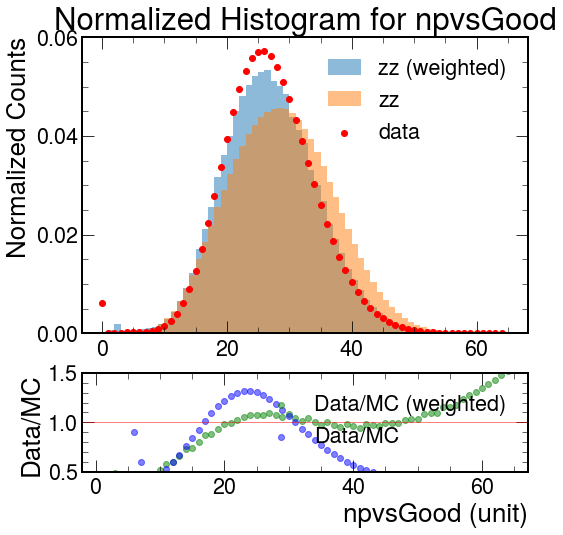

In [68]:
# 3. 计算三个变量的 Data/MC 比值
data_mc_ratios = {}
for group, variable in variables:
    data_hist, data_edges = np.histogram(combined_data[variable], bins=50)
    zz_hist, zz_edges = np.histogram(combined_zz[variable], bins=data_edges)
    
    # 归一化 data 和 zz 的直方图
    data_hist_normalized = data_hist / data_hist.sum()
    zz_hist_normalized = zz_hist / zz_hist.sum()
    
    # 计算归一化直方图的比值
    data_mc_ratios[variable] = (data_edges[:-1], data_hist_normalized / zz_hist_normalized)


# 4. 获取每个事件的综合pile-up权重
def get_weights(event_array, data_mc_ratios):
    pu_weights = []
    for variable, (bin_edges, ratio_values) in data_mc_ratios.items():
        bin_indices = np.digitize(event_array[variable], bin_edges) - 1
        pu_weights.append(ratio_values[bin_indices])
    return np.mean(np.array(pu_weights), axis=0)

pileup_weights = get_weights(combined_zz, data_mc_ratios)

# 5. 重新画出加权后的直方图
for group, variable in variables:
    plot_histogram(variable, combined_data, combined_zz, zz_weights=pileup_weights)




In [67]:
# 3. 计算三个变量的 Data/MC 比值
data_mc_ratios = {}
for group, variable in variables:
    data_hist, data_edges = np.histogram(combined_data[variable], bins=50)
    zz_hist, zz_edges = np.histogram(combined_zz[variable], bins=data_edges)
    
    # 归一化 data 和 zz 的直方图
    data_hist_normalized = data_hist / data_hist.sum()
    zz_hist_normalized = zz_hist / zz_hist.sum()
    
    # 计算归一化直方图的比值
    data_mc_ratios[variable] = (data_edges[:-1], data_hist_normalized / zz_hist_normalized)


# 获取每个事件的综合pile-up权重
def get_weights(event_final, sample, data_mc_ratios):
    pu_weights = []
    for variable, (bin_edges, ratio_values) in data_mc_ratios.items():
        if variable == 'npvsGood':
            array_key = 'npvsGood'
        elif variable == 'GridRhoFastjetCentralChargedPileUp':
            array_key = 'Rho_tracker'
        else:
            array_key = 'Rho_Calo'

        bin_indices = np.digitize(event_final[sample][array_key], bin_edges) - 1
        pu_weights.append(ratio_values[bin_indices])
    return np.mean(np.array(pu_weights), axis=0)

# 计算所有样本的pile-up权重
samples = ['zg', 'tt', 'zz', 'wz', 'ww']
all_pileup_weights = {}

for sample in samples:
    all_pileup_weights[sample] = get_weights(event_final, sample, data_mc_ratios)

# 打印权重
for sample, weights in all_pileup_weights.items():
    print(f"{sample}: {weights}")




zg: [1.13732457 1.13953578 1.2680693  ... 1.21378702 1.26240664 1.05210606]
tt: [0.85377484 0.78964663 1.05210606 ... 0.93504344 1.30874601 1.1711666 ]
zz: [0.8638046  0.57592047 1.14122518 1.0180449  0.97849641 1.13821401
 1.00440581 1.26898667 1.3076178  1.05686287 1.17861002 0.72696744
 0.6849229  1.22129141 1.23036011 0.96442694 0.77743123 1.10757411
 1.29620726 0.81324135 1.26929788 0.89923332 1.25683551 0.77743123
 1.09623222 1.3076178  1.20920936 1.21162435 1.00567627 1.21378702
 0.8638046  1.04110498 0.78964663 1.21378702 0.98140609 1.3076178
 1.13821401 1.21162435 1.26950872 1.26042491 1.2680693  0.8638046
 1.06486978 1.26042491 1.12254941 1.03327433 1.2695974  1.29620726
 1.10029849 0.90005495 0.66440484 1.3076178  1.07986801 1.03614794
 0.94731498 0.89961472 1.21728701 1.25333552 0.89570817 0.70851762
 1.10039251 0.96442694 0.95076619 1.02150672 1.29620726 1.26042491
 1.29651847]
wz: [1.29651847 1.29620726 1.09623222 ... 1.30730659 1.13984699 1.3076178 ]
ww: [1.10029849 1.26

/tmp/ipykernel_71166/2584002033.py:12: RuntimeWarning: divide by zero encountered in true_divide
  data_mc_ratios[variable] = (data_edges[:-1], data_hist_normalized / zz_hist_normalized)
/tmp/ipykernel_71166/2584002033.py:12: RuntimeWarning: invalid value encountered in true_divide
  data_mc_ratios[variable] = (data_edges[:-1], data_hist_normalized / zz_hist_normalized)


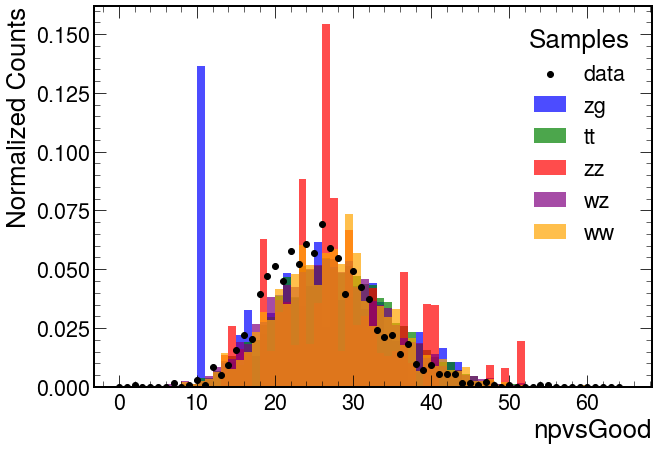

In [69]:
import matplotlib.pyplot as plt

def plot_weighted_npvsGood_histogram(event_final, all_pileup_weights):
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # 设置直方图参数
    bins = np.arange(0, 66, 1)
    alpha = 0.7
    
    # 绘制 data 散点图
    data_npvsGood = event_final['data']['npvsGood']
    data_hist, data_edges = np.histogram(data_npvsGood, bins=bins)
    data_hist_normalized = data_hist / data_hist.sum()
    plt.scatter(data_edges[:-1], data_hist_normalized, label='data', color='black', zorder=5)

    # 绘制经过 weight 后的样本的直方图
    samples = ['zg', 'tt', 'zz', 'wz', 'ww']
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    for sample, color in zip(samples, colors):
        weighted_npvsGood = event_final[sample]['npvsGood']
        weights = all_pileup_weights[sample]
        hist, edges = np.histogram(weighted_npvsGood, bins=bins, weights=weights)
        hist_normalized = hist / hist.sum()
        plt.hist(edges[:-1], bins, weights=hist_normalized, alpha=alpha, label=sample, color=color)
    
    # 设置坐标轴标签和图例
    plt.xlabel("npvsGood")
    plt.ylabel("Normalized Counts")
    plt.legend(title='Samples', loc='upper right')
    
    # 显示图形
    plt.show()

plot_weighted_npvsGood_histogram(event_final, all_pileup_weights)


## MuonSFs

In [90]:
BKG = {'zg','nonprompt','tt', 'zz', 'wz', 'ww'}
#BKG = {'tt', 'zz', 'wz', 'ww','nonprompt'}
#SIG = {'zg'}
# LUMI unit is fb
LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83, "2022": 4.5}
XSEC = {
    # unit is pb^-1
    'zg': 55.48,
    'tt': 101.78,
    'ww': 80.27,
    'wz': 29.14,
    'zz': 12.83,
}


In [ ]:
# 读取 ROOT 文件并获取 TH2D
file_muonSFs_weight = uproot.open("/home/pku/muty/pku/ZGToLLG/run3_zg_analyzer_change/MuonSFs/Efficiencies_muon_Z_Run2022.root")
#hist_muonSFs_weight = file_muonSFs_weight["NUM_IsoMu24_and_TightID_and_PFIsoTight_DEN_genTracks_eta_pt"]
hist_muonSFs_weight = file_muonSFs_weight["NUM_IsoMu24_DEN_TightID_and_PFIsoTight_eta_pt"]

correction = correctionlib.CorrectionSet.from_file('/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/LUM/2018_UL/puWeights.json.gz')['Collisions18_UltraLegacy_goldenJSON']

weight = {
    i: (
        fake_photon_weights if i == 'nonprompt' else
        (
#            correction.evaluate(np.array(event_final[i]['nPU']), "nominal") *
            all_pileup_weights[i] *
            np.sign(event_final[i]['generator_weight']) * XSEC[i] * LUMI['run3'] * 1e3 / 
            ak.sum(np.sign(event_final[i]['event_weight']))
        )
    ) for i in event_final if i != 'data'
}

# 将 TH2D 转换为 Awkward Array
muonSFs_weight_array = ak.Array(hist_muonSFs_weight.to_numpy()[0])

# 获取 muon1_pt、muon1_eta、muon2_pt 和 muon2_eta
muon1_pt = {i: event_final[i]['muon1_pt'] for i in event_final if i != 'data' and i != 'nonprompt'}
muon1_eta = {i: event_final[i]['muon1_eta'] for i in event_final if i != 'data' and i != 'nonprompt'}
muon2_pt = {i: event_final[i]['muon2_pt'] for i in event_final if i != 'data' and i != 'nonprompt'}
muon2_eta = {i: event_final[i]['muon2_eta'] for i in event_final if i != 'data' and i != 'nonprompt'}

# 限制 muon_pt 的最大值
for key in muon1_pt:
    muon1_pt[key] = ak.where(muon1_pt[key] > 120, 119.9, muon1_pt[key])
    muon2_pt[key] = ak.where(muon2_pt[key] > 120, 119.9, muon2_pt[key])
    muon1_eta[key] = ak.where(muon1_pt[key] > 2.4, 2.39, muon1_eta[key])
    muon2_eta[key] = ak.where(muon2_pt[key] > 2.4, 2.39, muon2_eta[key])

# 获取 TH2D 的 bin 边缘
xedges = hist_muonSFs_weight.axis(0).edges()
yedges = hist_muonSFs_weight.axis(1).edges()

# 计算 muon_eta 和 muon_pt 的 bin 索引
x_bin_indices1 = {key: np.digitize(muon1_eta[key], xedges) - 1 for key in muon1_eta}
y_bin_indices1 = {key: np.digitize(muon1_pt[key], yedges) - 1 for key in muon1_pt}
x_bin_indices2 = {key: np.digitize(muon2_eta[key], xedges) - 1 for key in muon2_eta}
y_bin_indices2 = {key: np.digitize(muon2_pt[key], yedges) - 1 for key in muon2_pt}

# 使用 bin 索引从 muonSFs_weight_array 中获取权重
muonSFs_weights1 = {key: muonSFs_weight_array[x_bin_indices1[key], y_bin_indices1[key]] for key in x_bin_indices1}
muonSFs_weights2 = {key: muonSFs_weight_array[x_bin_indices2[key], y_bin_indices2[key]] for key in x_bin_indices2}

# 计算总的 muonSFs 权重
muonSFs_weights = {}
for key in muonSFs_weights1:
    muonSFs_weights[key] = muonSFs_weights1[key] + muonSFs_weights2[key] - muonSFs_weights1[key] * muonSFs_weights2[key]

# 将 Muon SFs 权重应用于 MC 事件
for key in event_final:
    if key != 'data' and key != 'nonprompt':
        weight[key] = weight[key] * muonSFs_weights[key]



## testing plot
### only run for a test, without PU weight and SFs.

In [7]:
BKG = {'tt', 'zz', 'wz', 'ww','nonprompt','zg'}
#BKG = {'tt', 'zz', 'wz', 'ww','nonprompt'}
#SIG = {'zg'}
# LUMI unit is fb
LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83, "run3": 4.5}
XSEC = {
    # unit is pb^-1
    'zg': 55.48,
    'tt': 101.78,
    'ww': 80.27,
    'wz': 29.14,
    'zz': 12.83,
}

# * xs_weight * pu_weight

In [8]:
correction = correctionlib.CorrectionSet.from_file('/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/LUM/2018_UL/puWeights.json.gz')['Collisions18_UltraLegacy_goldenJSON']
weight = {
    i: (
        fake_photon_weights if i == 'nonprompt' else
        (
            np.sign(event_final[i]['generator_weight']) * XSEC[i] * LUMI['run3'] * 1e3 / 
            ak.sum(np.sign(event_final[i]['event_weight']))
        )
    ) for i in event_final if i != 'data'
}

In [16]:
weight

{'zg': <Array [0.152, -0.17, 0.169, ... -0.166, 0.175] type='10500 * ?float64'>,
 'tt': <Array [0.00622, 0.00636, ... 0.0054, 0.00553] type='4674 * ?float64'>,
 'zz': <Array [0.0557, 0.0316, ... 0.0481, 0.0511] type='67 * ?float64'>,
 'ww': <Array [0.00643, 0.00653, ... 0.00576, 0.00742] type='703 * ?float64'>,
 'wz': <Array [0.00469, 0.00475, ... 0.00469, 0.00476] type='4311 * ?float64'>,
 'nonprompt': <Array [0.0532, 0.0656, ... 0.0532, 0.0262] type='1419 * float64'>}

## Plot

In [74]:
event_final_2 = {
    'data':event_final['data'],
    'tt':event_final['tt'],
    'ww':event_final['ww'],
    'wz':event_final['wz'],
    'zz':event_final['zz'],
    'nonprompt':event_final['nonprompt'],
    'zg':event_final['zg'],
}

In [75]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    return np.array([down_error_bar, up_error_bar])

#weight={y: {c: events[y][c].event_weight for c in events[y] if c!='data' and len(events[y][c])>0} for y in events}


In [91]:
from matplotlib.cm import get_cmap
from matplotlib.ticker import ScalarFormatter

hep.style.use("CMS")
#mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab20").colors)
#print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

def data_mc_compare_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='run3', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, fraction_log=False):
    density = False
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
      
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
#    hep.cms.label(data=True, year=year, ax=ax, lumi="4.5 fb^{-1} (13.6 TeV)", fontsize=18, llabel='Preliminary')

    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}

    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        
#        if k!='data' and k!= 'nonprompt' and weight is not None:
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
#            if k=='nonprompt':
        else:
            hist.fill(values)


        
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var
            

    ## plot
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=['darkorange', 'cyan', 'HotPink', 'darkviolet', 'SlateGray', 'black', 'LightSkyBlue'])
#    SIG_COLOR={'zg': 'red'}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=density, stack=True, linewidth=2, ax=ax)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        # we usually don't care error of background MC cuz the stats is very large (relative error is very small compared with signal and data)
    for (k,h) in individual['h'].items():
        if k=='data':
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
        elif k == 'nonprompt':
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
        else:  # signal
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(bkg_h + 1)
    #        hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])

    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))

    
    if not density:
        ax.set_yscale('log')
#    ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2.4)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    ax1.ticklabel_format(useOffset=False, style='scientific')

    # xticks = np.arange(x_min, x_max + 1,20)  # 根据需要调整间隔
    # xticklabels = [str(tick) for tick in xticks]
    # ax1.set_xticks(xticks)
    # ax1.set_xticklabels(xticklabels, fontsize=16)   

#    ax1.set_xticks(ax.get_xticks())
#    ax1.set_xticklabels(ax.get_xticklabels())

    plt.xticks(size=16)
    plt.yticks(size=16)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=15)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/{year}_{plot_name}{suffix}_ABCD_muonSFs.pdf", bbox_inches='tight')
    plt.show()

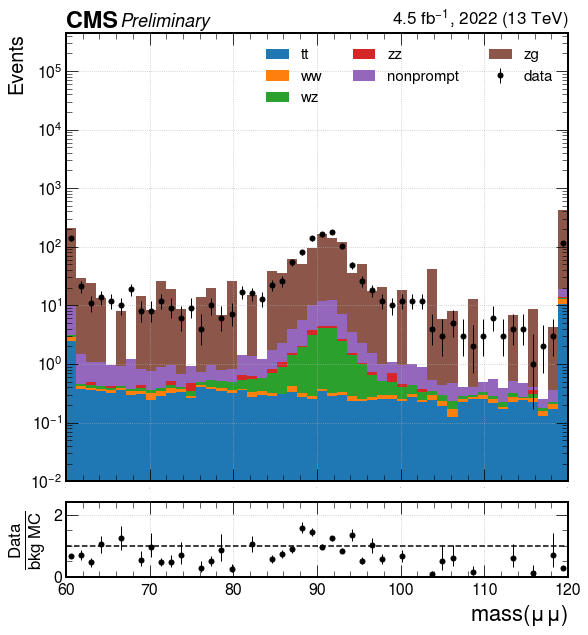

In [92]:
#tesing plot
arrays={
    k: event_final_2[k]['muon_mass'] for k in event_final_2 
#    k: event_final_2[k]['photon_eta'][:,0] for k in event_final_2 
}
data_mc_compare_plot(arrays, weight=weight, plot_name='muon_mass', x_name=r'$mass (\mu \mu)$', x_max=120, x_min=60, bins=50, year='2022', density=True, underflow=True)

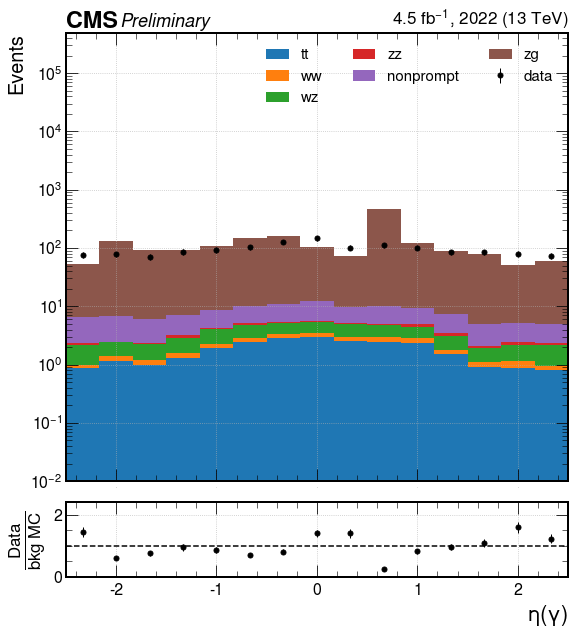

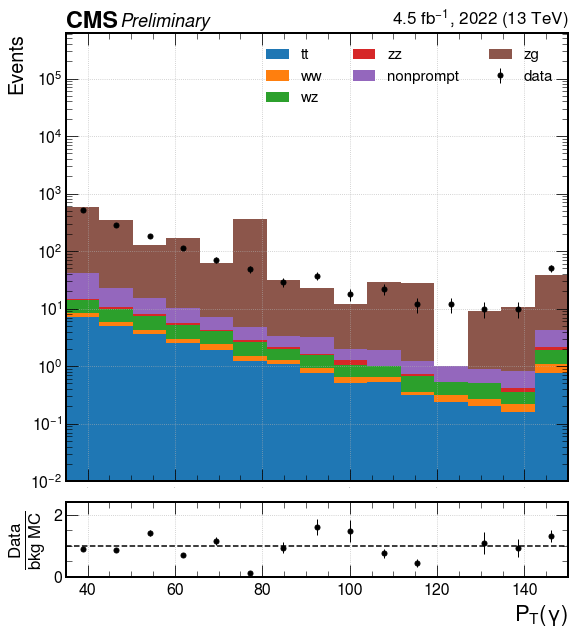

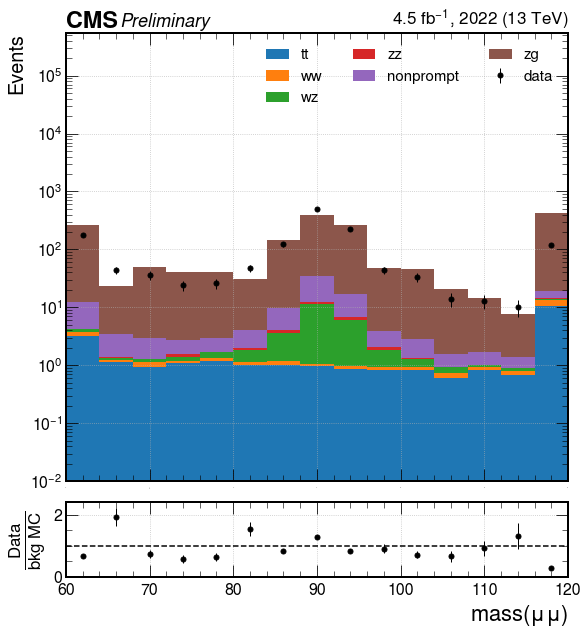

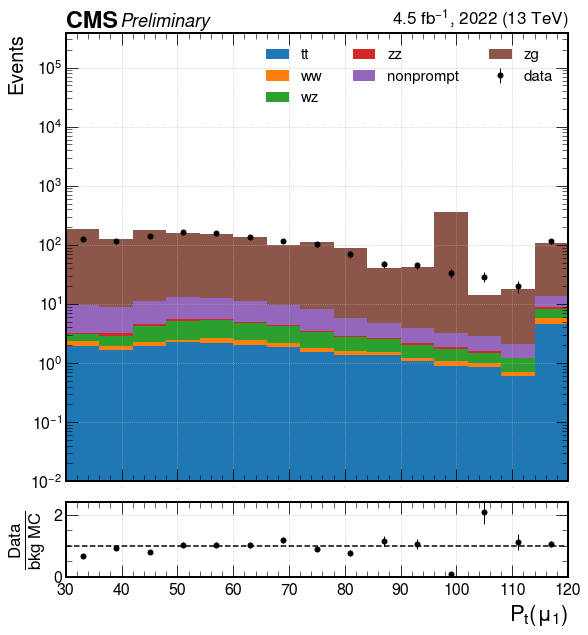

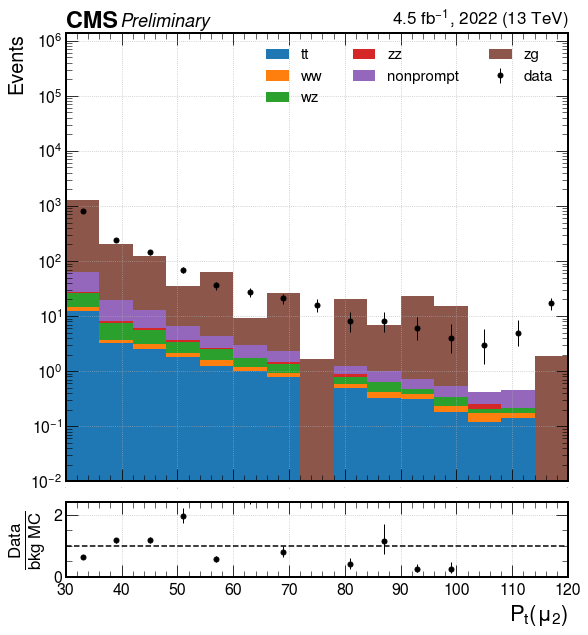

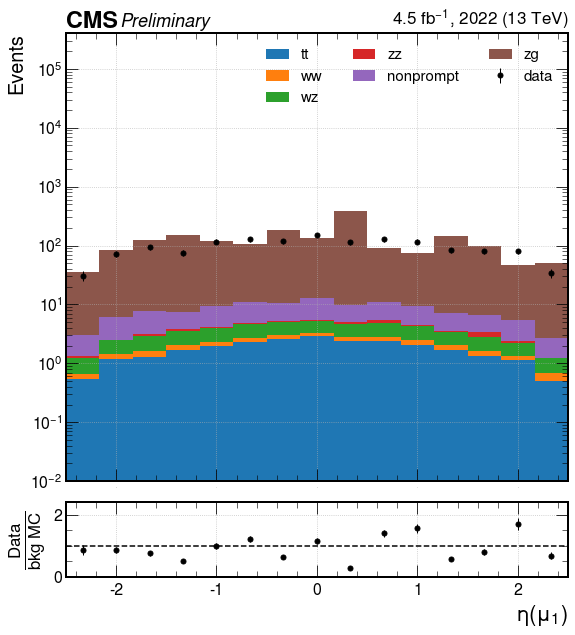

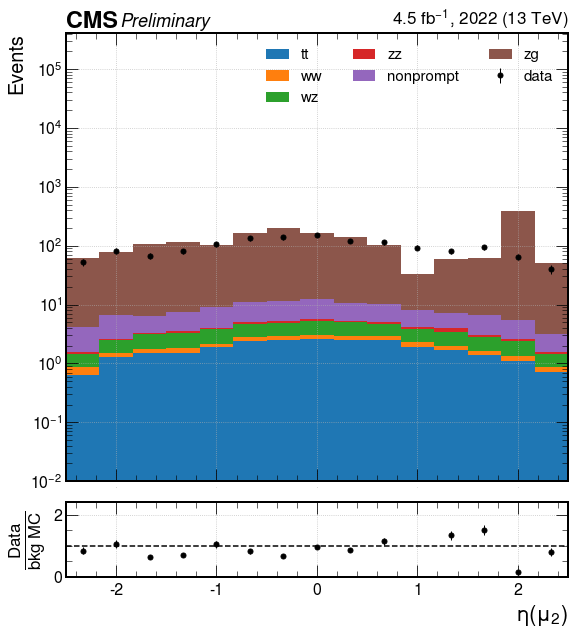

In [93]:
#plot all
plot_info = [
    ('photon_eta', r'$\eta (\gamma)$', 'photon_eta', -2.5, 2.5, 15, True),
    ('photon_pt', r'$P_T (\gamma)$', 'photon_pt', 35, 150, 15, True),
    ('muon_mass', r'$mass (\mu \mu)$', 'muon_mass', 60, 120, 15, False),
    ('muon1_pt', r'$P_t (\mu_1)$', 'muon1_pt', 30, 120, 15, False),
    ('muon2_pt', r'$P_t (\mu_2)$', 'muon2_pt', 30, 120, 15, False),
    ('muon1_eta', r'$\eta (\mu_1)$', 'muon1_eta', -2.5, 2.5, 15, False),
    ('muon2_eta', r'$\eta (\mu_2)$', 'muon2_eta', -2.5, 2.5, 15, False),
]

for plot_name, x_name, var_name, x_min, x_max, bins, is_photon in plot_info:
    arrays = {k: event_final_2[k][var_name] for k in event_final_2}
    if is_photon:
        arrays = {k: v[:, 0] for k, v in arrays.items()}
    
    data_mc_compare_plot(arrays, weight=weight, plot_name=plot_name, x_name=x_name, x_min=x_min, x_max=x_max, bins=bins, year='2022', density=True, underflow=True)


In [ ]:
event_test = ak.concatenate(event_muon_phodrs['wz'])



In [ ]:
ak.max(event_final.ntuple.Generator_weight)

In [ ]:

"""
lumi = 4.9 fb
"""

xs_weight = lumi * xsec / ak.sum(genWeight)


## 测试

In [ ]:
event_final = {key: {} for key in EVENT}
#print(event_final)
for key in EVENT.keys():
#    event_final[key] = ak.concatenate(ak.Array(event_muon_phodrs[key]))
    event_final[key] = ak.concatenate(event_muon_phodrs[key])
    print(key,'done')
event_final
event_final['data'] = event_final['muonc']
del event_final['muonc']

In [ ]:
import selection_cut 
reload(selection_cut)
i = EVENT['zg'][0]
mu1 = selection_cut.muon(i,'trigger','IsoMu24')
print(mu1)
mu2 = selection_cut.muon(mu1,'cutBasedID','tight')
print(mu2)
mu3 = selection_cut.muon(mu2,'pf','tight')
print(mu3)
mu4 = selection_cut.muon(mu3,'pid','+-')
print(mu4)
mu5 = selection_cut.muon(mu4,'pt','2025')
print(mu5)
mu6 = selection_cut.muon(mu5,'eta','2.4')
print(mu6)
#    event_muon_phodr.append(mu6)
#photon_cut
pho1 = selection_cut.photon(mu6, 'pt', '10')
print(pho1)
pho2 = selection_cut.photon(pho1, 'eta', '2.5')
print(pho2)
pho3 = selection_cut.photon(pho2, 'id', 'tight')
print(pho3)
pho4 = selection_cut.photon(pho3,'prompt',True)
print(pho4)
gen_photon = pho4.GenPart[(pho4.GenPart.pdgId==22) & pho4.GenPart.hasFlags([ "isPrompt", 'isLastCopy'])]
photon4_near, photon4_gen_photon_dr = gen_photon.nearest(pho4.Photon, axis=1, return_metric=True)
mask = ak.fill_none(photon4_gen_photon_dr < 0.3, True)
pho5 = pho4[ak.num(pho4.Photon[ak.any(mask == True,axis=1)]) == 1]
#pho5 = pho4[ak.num(pho4.Photon[mask]) == 1]
print(pho5)

In [ ]:
pho5.Muon.pt
#pho5.Muon[:,1]

In [ ]:
muon_vectors = ak.zip(
    {
        "pt": pho5["Muon"]["pt"],
        "eta": pho5["Muon"]["eta"],
        "phi": pho5["Muon"]["phi"],
        "mass": pho5["Muon"]["mass"],
    },
    with_name="PtEtaPhiMLorentzVector",
)

# 确保每个事件都有两个 muon
muon_pairs = muon_vectors[ak.num(muon_vectors) == 2]

# 计算两个 muon 的联合不变质量
invariant_mass = (muon_pairs[:, 0] + muon_pairs[:, 1]).mass

print("Invariant mass:", invariant_mass)
invariant_mass
#pho5

In [ ]:
mask = ak.fill_none(photon4_gen_photon_dr < 0.3, True)
print(mask)
pho4[ak.num(pho4.Photon[ak.any(mask == True,axis=1)]) == 1]
#pho4.Photon
#ak.num(pho4.Photon[mask])
#pho4
#pho5 = pho4[ak.num(pho4.Photon[mask]) == 1]
#print(pho5)

In [ ]:
event_muon_phodr = []
photon4_near, photon4_gen_photon_dr = gen_photon.nearest(pho4.Photon, axis=1, return_metric=True, threshold=0.003)
photon4_near.charge
mask = ak.fill_none(photon4_gen_photon_dr < 0.3, True)
mask
#[photon4_near.charge == None]

pho5 = pho4[ak.num(pho4.Photon[mask]) == 1]
VARIABLES = {
    'photon_pt':pho5.Photon.pt,
    'photon_eta':pho5.Photon.eta,
#    'tt': ttbar_events,
#    'zz': zz_events,
#    'wz': wz_events,
#    'ww': ww_events,
}
event_muon_phodr.append(VARIABLES)
event_muon_phodr
#event_muon_phodrs[zg] = VARIABLES

In [ ]:
VARIABLES = {
    'photon_pt':pho5.Photon.pt,
    'photon_eta':pho5.Photon.eta,
#    'tt': ttbar_events,
#    'zz': zz_events,
#    'wz': wz_events,
#    'ww': ww_events,
}

In [ ]:
photon4_near, photon4_gen_photon_dr = gen_photon.nearest(pho4.Photon, axis=1, return_metric=True)#, threshold=0.3
ak.fill_none(photon4_gen_photon_dr < 0.3, False)
#pho4[ak.num(photon4_near) != 0]

In [ ]:
ak.min(ak.num(gen_photon))

In [ ]:
reload(selection_cut)
event_muon_pho = []
for event_muon_x in event_muon:
    pho1 = selection_cut.photon(event_muon_x,'pt','10')
    pho2 = selection_cut.photon(pho1,'eta','2.5')
    pho3 = selection_cut.photon(pho2,'id','tight')
    pho4 = selection_cut.photon(pho3,'prompt',True)
    event_muon_pho.append(pho4)

In [ ]:
reload(selection_cut)
event_muon_phodr = []
for event_muon_pho_x in event_muon_pho:
    gen_photon = event_muon_pho_x.GenPart[(event_muon_pho_x.GenPart.pdgId==22) & event_muon_pho_x.GenPart.hasFlags(["fromHardProcess", "isPrompt"])]
    dr_photon = selection_cut.DR(event_muon_pho_x.Photon, gen_photon, drmin=0.3)
    dr_cut = (ak.num(event_muon_pho_x.Photon[dr_photon]) != 0)
    event_muon_phodr.append(event_muon_pho_x[dr_cut])

In [ ]:
reload(selection)
p = selection.DR(c.Photon, gen_photon, drmin=0.3)
dr_cut = (ak.num(c.Photon[p]) != 0)
c[dr_cut]


In [ ]:
p

In [ ]:
b.GenPart.hasFlags(["fromHardProcess", "isPrompt"])

In [ ]:
_events.Photon[0,0].delta_r(gen_photon)

In [ ]:

def muon(sample,cut_name,tag):
    if cut_name == 'trigger':
        if tag == 'IsoMu24':
            return sample[sample.HLT.IsoMu24]
    if cut_name == 'cutBasedID':
        if tag == 'tight':
            cutBasedID_raw = ak.unzip(sample.ntuple.muon_cutBasedID[:,0,:])
            cutBasedID_raw = ak.flatten(cutBasedID_raw)
            muon_cutBasedID_cut = cutBasedID_raw[cutBasedID_raw != -10000000]
            return sample[(ak.all(muon_cutBasedID_cut[:,:] == 3, axis=1))]
    if cut_name == 'pf':
        if tag == 'tight':
            return sample[(ak.all(sample.Muon.pfRelIso04_all[:,:] < 0.15, axis=1))]
    if cut_name == 'pid':
        if tag == '+-':
            pid_raw = ak.unzip(sample.ntuple.muon_pid[:,0,:])
            pid_raw = ak.flatten(pid_raw)
            pid_cut = pid_raw[  (pid_raw == 13) | (pid_raw == -13)]
            return sample[ak.sum(pid_cut[:,:2], axis=1)==0 ]
    if cut_name == 'pt':
        if tag == '2025':
            pt_raw = ak.unzip(sample.ntuple.muon_pt[:,0,:])
            pt_raw = ak.flatten(pt_raw)
            pt_cut = pt_raw[pt_raw != -1e+07]
            return sample[(ak.all(pt_cut[:,:] > 20, axis=1)) & (ak.any(pt_cut[:,:] > 25, axis=1))]
    if cut_name == 'eta':
        if tag == '2.4':
            eta_raw = ak.unzip(sample.ntuple.muon_eta[:,0,:])
            eta_raw = ak.flatten(eta_raw)
            eta_cut = eta_raw[eta_raw != -1e+07]
            return  sample[(ak.all(eta_cut[:,:] < 2.4, axis=1))] 

        


In [ ]:
def photon(sample,cut_name,tag):
    if cut_name == 'pt':
        if tag == '10':
            photon_pt = ak.unzip(sample.ntuple.photon_pt[:,0,:])
            photon_pt = ak.flatten(photon_pt)
            pt_cut = photon_pt[photon_pt != -1e+07]
            return sample[(ak.any(pt_cut[:,:] > 10, axis=1))]
    if cut_name == 'eta':
        if tag =='2.5':
            photon_eta = ak.unzip(sample.ntuple.photon_eta[:,0,:])
            photon_eta = ak.flatten(photon_eta)
            eta_cut = photon_eta[photon_eta != -1e+07]
            return sample[(ak.any(eta_cut[:,:] < 2.5, axis=1))]
    if cut_name == 'id':
        if tag == 'tight':
            pt_id = (sample.Photon.vidNestedWPBitmap[:] & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 1) & 1) 
            scEta_id = (sample.Photon.vidNestedWPBitmap[:] >> 2 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 3) & 1) 
            HoE_id = (sample.Photon.vidNestedWPBitmap[:] >> 4 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 5) & 1) 
            siesie_id = (sample.Photon.vidNestedWPBitmap[:] >> 6 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 7) & 1) 
            chiso_id = (sample.Photon.vidNestedWPBitmap[:] >> 8 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 9) & 1) 
            neuiso_id = (sample.Photon.vidNestedWPBitmap[:] >> 10 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 11) & 1) 
            phoiso_id = (sample.Photon.vidNestedWPBitmap[:] >> 12 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 13) & 1)
            return sample[(ak.any(pt_id ==3, axis = 1)) &  (ak.any(scEta_id ==3, axis = 1)) & (ak.any(HoE_id ==3, axis = 1)) & (ak.any(siesie_id ==3, axis = 1)) & (ak.any(chiso_id ==3, axis = 1)) & (ak.any(neuiso_id ==3, axis = 1)) & (ak.any(phoiso_id ==3, axis = 1))]
    if cut_name == 'prompt':
        photon_prompt = sample.Photon.genPartFlav[sample. Photon.genPartFlav== 1]
        return sample[(ak.all(photon_prompt == 1, axis=1))]






In [ ]:
result2 = []
for zg_event in zg_events:
    mu1 = muon(zg_event,'trigger','IsoMu24')
    mu2 = muon(mu1,'cutBasedID','tight')
    mu3 = muon(mu2,'pf','tight')
    '''
    mu4 = muon(mu3,'pid','+-')
    mu5 = muon(mu4,'pt','2025')
    mu6 = muon(mu5,'eta','2.4')
    '''
    result2.append(mu3)
        

In [ ]:
def processor(events: NanoEventsArray,type) -> ak.Array:
    if type == 'MC':
        print('MC')
        cutBasedID_raw = ak.unzip(events.ntuple.muon_cutBasedID[:,0,:])
        cutBasedID_raw = ak.flatten(cutBasedID_raw)
        muon_cutBasedID_cut = cutBasedID_raw[cutBasedID_raw != -10000000]
        events_cut = events[(events.HLT.IsoMu24) & (ak.all(muon_cutBasedID_cut[:,:] == 3, axis=1)) & (ak.all(events.Muon.pfRelIso04_all[:,:] < 0.15, axis=1))]

    return ak.Array(events_cut)

In [ ]:
result = ak.concatenate([processor(i,'MC') for i in zg_events], axis=0)

In [ ]:
_events = NanoEventsFactory.from_root(
    file='/data/pku/home/muty/pku/ZGToLLG/DATA_MC/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2022/230314_063436/0000/tree_10.root',
    treepath='Events', schemaclass=NanoAODSchema
).events()

In [ ]:
gen_photon = _events.GenPart[
    (_events.GenPart.pdgId==22) &
    _events.GenPart.hasFlags(["fromHardProcess", "isLastCopy"])
][0, 0]

In [ ]:
_events.GenPart.hasFlags(['fromHardProcess', 'isLastCopy'])

In [ ]:
SFs_file = uproot.open('/home/pku/muty/pku/ZGToLLG/run3_zg_analyzer/MuonSFs/Efficiencies_muon_Z_Run2022.root')
SFs_file['NUM_IsoMu24_and_TightID_and_PFIsoTight_DEN_genTracks_eta_pt'].values()
print(SFs_file['NUM_IsoMu24_and_TightID_and_PFIsoTight_DEN_genTracks_eta_pt'].axes[0].edges())
print(SFs_file['NUM_IsoMu24_and_TightID_and_PFIsoTight_DEN_genTracks_eta_pt'].axes[1].edges())

In [ ]:
#print(_events.Muon.fields)
print(_events.Photon.genPartFlav[0])
#_events.HLT.IsoMu24
#_events.GenMET['phi']
#_events.ntuple['photon_pt'][0,0,:]
#_events.ntuple['GenPart_status']

In [ ]:
for zg_event in zg_events:
    print(zg_event.Photon.genPartFlav[0])

### overflow定义

In [ ]:
def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: ## h, var also include underflow bins but in plots usually no underflow data
        ## And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2]+=h[-1]; var[-2]+=var[-1]
    if underflow:
        h[1]+=h[0]; var[1]+=var[0]
    if overflow or underflow:
        h = h[1:-1]; var = var[1:-1]
    return h, var

## 成功的cut

### muon cut

In [ ]:

def muon(sample,cut_name,tag):
    if cut_name == 'trigger':
        if tag == 'IsoMu24':
            return sample[sample.HLT.IsoMu24]
    if cut_name == 'cutBasedID':
        if tag == 'tight':
            cutBasedID_raw = ak.unzip(sample.ntuple.muon_cutBasedID[:,0,:])
            cutBasedID_raw = ak.flatten(cutBasedID_raw)
            muon_cutBasedID_cut = cutBasedID_raw[cutBasedID_raw != -10000000]
            return sample[(ak.all(muon_cutBasedID_cut[:,:] == 3, axis=1))]
    if cut_name == 'pf':
        if tag == 'tight':
            return sample[(ak.all(sample.Muon.pfRelIso04_all[:,:] < 0.15, axis=1))]
    if cut_name == 'pid':
        if tag == '+-':
            pid_raw = ak.unzip(sample.ntuple.muon_pid[:,0,:])
            pid_raw = ak.flatten(pid_raw)
            pid_cut = pid_raw[  (pid_raw == 13) | (pid_raw == -13)]
            return sample[ak.sum(pid_cut[:,:2], axis=1)==0 ]
    if cut_name == 'pt':
        if tag == '2025':
            pt_raw = ak.unzip(sample.ntuple.muon_pt[:,0,:])
            pt_raw = ak.flatten(pt_raw)
            pt_cut = pt_raw[pt_raw != -1e+07]
            return sample[(ak.all(pt_cut[:,:] > 20, axis=1)) & (ak.any(pt_cut[:,:] > 25, axis=1))]
    if cut_name == 'eta':
        if tag == '2.4':
            eta_raw = ak.unzip(sample.ntuple.muon_eta[:,0,:])
            eta_raw = ak.flatten(eta_raw)
            eta_cut = eta_raw[eta_raw != -1e+07]
            return  sample[(ak.all(eta_cut[:,:] < 2.4, axis=1))] 

        


### photon cut

In [ ]:
def photon(sample,cut_name,tag):
    if cut_name == 'pt':
        if tag == '10':
            photon_pt = ak.unzip(sample.ntuple.photon_pt[:,0,:])
            photon_pt = ak.flatten(photon_pt)
            pt_cut = photon_pt[photon_pt != -1e+07]
            return sample[(ak.any(pt_cut[:,:] > 10, axis=1))]
    if cut_name == 'eta':
        if tag =='2.5':
            photon_eta = ak.unzip(sample.ntuple.photon_eta[:,0,:])
            photon_eta = ak.flatten(photon_eta)
            eta_cut = photon_eta[photon_eta != -1e+07]
            return sample[(ak.any(eta_cut[:,:] < 2.5, axis=1))]
    if cut_name == 'id':
        if tag == 'tight':
            pt_id = (sample.Photon.vidNestedWPBitmap[:] & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 1) & 1) 
            scEta_id = (sample.Photon.vidNestedWPBitmap[:] >> 2 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 3) & 1) 
            HoE_id = (sample.Photon.vidNestedWPBitmap[:] >> 4 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 5) & 1) 
            siesie_id = (sample.Photon.vidNestedWPBitmap[:] >> 6 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 7) & 1) 
            chiso_id = (sample.Photon.vidNestedWPBitmap[:] >> 8 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 9) & 1) 
            neuiso_id = (sample.Photon.vidNestedWPBitmap[:] >> 10 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 11) & 1) 
            phoiso_id = (sample.Photon.vidNestedWPBitmap[:] >> 12 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 13) & 1)
            return sample[(ak.any(pt_id ==3, axis = 1)) &  (ak.any(scEta_id ==3, axis = 1)) & (ak.any(HoE_id ==3, axis = 1)) & (ak.any(siesie_id ==3, axis = 1)) & (ak.any(chiso_id ==3, axis = 1)) & (ak.any(neuiso_id ==3, axis = 1)) & (ak.any(phoiso_id ==3, axis = 1))]
    if cut_name == 'prompt':
        photon_prompt = sample.Photon.genPartFlav[sample. Photon.genPartFlav== 1]
        return sample[(ak.all(photon_prompt == 1, axis=1))]






In [ ]:
mu1 = muon(_events,'trigger','IsoMu24')
mu2 = muon(mu1,'cutBasedID','tight')

In [ ]:
mu2

In [ ]:
mu1 = muon(_events,'trigger','IsoMu24')
mu2 = muon(mu1,'cutBasedID','tight')
mu3 = muon(mu2,'pf','tight')
mu4 = muon(mu3,'pid','+-')
mu5 = muon(mu4,'pt','2025')
mu6 = muon(mu5,'eta','2.4')

In [ ]:
mu6

In [ ]:
pho1 = photon(mu6,'pt','10')
pho2 = photon(pho1,'eta','2.5')
pho3 = photon(pho2,'id','tight')
pho4 = photon(pho3,'prompt',True)

In [ ]:
#pho4.object = {}
pho4.object

## plot

In [ ]:
set_bins=[100.,150.,200.,300.,400.,500.]
x_min=90 
x_max=501

In [ ]:
def plot(samples, variable, bins=set_bins,overflow=True,underflow=False, density=False, stack=False):
#def plot(samples, variable, bins=[100.,150.,200.,300.,400.,500.],overflow=True,underflow=False, density=False, stack=False):
## canvas initializing
    colorlist=['red', 'blue', 'green', 'black', 'cyan', 'darkorange', 'darkviolet', 'SlateGray', 'HotPink', 'LightSkyBlue']
    mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    #f, ax = plt.subplots()
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data=False, year=2022, ax=ax)
    #画图定义
#set_bins=[400.,600.,800.,1200.,1600.,2000.,3000.]

#    hep.cms.label(data=False, year=MC, ax=ax)
    plot_weight = {
        'new': 4.9*0.94*1000/791074,
        'old': 4.9*0.96*1000/81266
    }
    plot_hist = {
        'new': bh.Histogram(bh.axis.Variable(set_bins), storage=bh.storage.Weight()),
        'old': bh.Histogram(bh.axis.Variable(set_bins), storage=bh.storage.Weight())
    }
    plot_hep = {
        'new': hep,
        'old': hep
    }

## plot
    for key in filedict:
        plot_hist[key].fill(photon_pt[key], weight= events[key]['LHEReweightingWeight'][:,8]*plot_weight[key])
        h, var = flow(hist=plot_hist[key], overflow=overflow, underflow=underflow)
        print(plot_hist[key])
        plot_hep[key].histplot(h, bins=plot_hist[key].axes[0].edges, yerr=np.sqrt(var), label=key, histtype='step', density=density, stack=stack)
        

#    hist = bh.Histogram(bh.axis.Variable(set_bins), storage=bh.storage.Weight())
#    hist.fill(photon_pt['new'], weight= events['new']['LHEReweightingWeight'][:,8]*139*0.94*1000/791074)
#    h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
#    print(hist)
#    return hist
#    h, err = hist.view().value, np.sqrt(hist.view().variance)

#    hep.histplot(h, bins=hist.axes[0].edges, yerr=np.sqrt(var), label='sm_pt', histtype='step', density=density, stack=stack)
#    print(np.sqrt(var))
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too) 


## axises
    plt.xlim(x_min, x_max)
#    plt.xlim(0, 500)
#    plt.ylim(0, ax.get_ylim()[1]*1.1) 
    ax.ticklabel_format(useOffset=False, style='plain')
    plt.yscale('log') 

    if density==False:
        plt.ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        plt.ylabel('A.U.', fontsize=20, ha='right', y=1)
    plt.xlabel('photon_pt', fontsize=20, ha='right', x=1)

    plt.xticks(size=16)
    plt.yticks(size=16)
    
    ## title, text and legend
    #plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    plt.legend(loc="best", ncol=1, frameon=False, fontsize=20)
    #plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')


    ## finalizing
    if density==True:   suffix='_AU'
    if stack==True:     suffix='_stack'
#    plt.savefig("plots/"+'M_mumu2'+suffix+".pdf", bbox_inches='tight')
    plt.savefig("plot/"+'photon_pt_new'+".pdf", bbox_inches='tight')
    plt.show()
#    return hist

In [ ]:
plot(samples=photon_pt['new'],  variable='nan')
#新物理参数的置信度 新物理参数和标准模型作对比（weight ratio加权） 直方图就是标准模型的结果 二次函数拟合想得到新物理参数和标准模型之间的差异

## 测试的cut

In [ ]:
use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

set_bins = [0.,10.,15.,20.,40.,60.,100.,200.]
def plot(samples, bins=set_bins, density=False, stack=False):
#def plot(samples, variable, bins=[100.,150.,200.,300.,400.,500.],overflow=True,underflow=False, density=False, stack=False):
## canvas initializing
    colorlist=['red', 'blue', 'green', 'black', 'cyan', 'darkorange', 'darkviolet', 'SlateGray', 'HotPink', 'LightSkyBlue']
    mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    #f, ax = plt.subplots()
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    plt.yscale('log')
    hep.cms.label(data=False, year=2022, ax=ax)
    plot_hist = bh.Histogram(bh.axis.Variable(set_bins), storage=bh.storage.Weight())
    plot_hist.fill(samples, weight=1)
    h, err = plot_hist.view().value, np.sqrt(plot_hist.view().variance)
    plot_hep = hep
    plot_hep.histplot(h, bins=plot_hist.axes[0].edges, yerr=err, label="muon_pt", histtype='step', density=density, stack=stack)
    plt.show()

In [ ]:
plot(samples=pho4.ntuple.muon_pt[:,0,1])

In [ ]:
####原始cut
#trigger(HLT_IsoMu24)
'''
mu1 = _events[_events.HLT.IsoMu24]
mu1
print(mu1[2].pt)
'''

#Tight CutBased ID & Tight PF isolation for two muons 
'''
cutBasedID_raw = ak.unzip(mu1.ntuple.muon_cutBasedID[:,0,:])
cutBasedID_raw = ak.flatten(cutBasedID_raw)
muon_cutBasedID_cut = cutBasedID_raw[cutBasedID_raw != -10000000]
muon_cutBasedID_pf_cut = (ak.all(muon_cutBasedID_cut[:,:] == 3, axis=1)) & (ak.all(mu1.Muon.pfRelIso04_all[:,:] < 0.15, axis=1))
mu2 = mu1[muon_cutBasedID_pf_cut]
mu2
'''

#two muon and with opposite charge
'''
pid_raw = ak.unzip(mu2.ntuple.muon_pid[:,0,:])
pid_raw = ak.flatten(pid_raw)
pid_cut = pid_raw[  (pid_raw == 13) | (pid_raw == -13)]
muon_pid_cut = ak.sum(pid_cut[:,:2], axis=1)==0 
mu3 = mu2[muon_pid_cut]
mu3
#print(mu2.pt[100])
'''

#all the muons>20，ar least one muon>35 
'''
pt_raw = ak.unzip(mu3.ntuple.muon_pt[:,0,:])
pt_raw = ak.flatten(pt_raw)
pt_cut = pt_raw[pt_raw != -1e+07]
muon_pt_cut = (ak.all(pt_cut[:,:] > 20, axis=1)) & (ak.any(pt_cut[:,:] > 35, axis=1))
mu4 = mu3[muon_pt_cut]
mu4
#print(mu3[2].pt)
'''

#all the eta<2.4 
'''
eta_raw = ak.unzip(mu4.ntuple.muon_eta[:,0,:])
eta_raw = ak.flatten(eta_raw)
eta_cut = eta_raw[eta_raw != -1e+07]
muon_eta_cut = (ak.all(eta_cut[:,:] < 2.4, axis=1)) 
event_mu = mu4[muon_eta_cut]
event_mu
'''

#any photon pt>10 
'''
photon_pt = ak.unzip(event_mu.ntuple.photon_pt[:,0,:])
photon_pt = ak.flatten(photon_pt)
pt_cut = photon_pt[photon_pt != -1e+07]
photon_pt_cut = (ak.any(pt_cut[:,:] > 10, axis=1))
photon1 = event_mu[photon_pt_cut]
photon1
'''

#any photon eta < 2.5 
'''
photon_eta = ak.unzip(photon1.ntuple.photon_eta[:,0,:])
photon_eta = ak.flatten(photon_eta)
eta_cut = photon_eta[photon_eta != -1e+07]
photon_eta_cut = (ak.any(eta_cut[:,:] < 2.5, axis=1))
photon2 = photon1[photon_eta_cut]
photon2
'''


# determine photon id
'''
pt_id = (photon2.Photon.vidNestedWPBitmap[:] & 1) + 2*((photon2.Photon.vidNestedWPBitmap[:] >> 1) & 1) 
scEta_id = (photon2.Photon.vidNestedWPBitmap[:] >> 2 & 1) + 2*((photon2.Photon.vidNestedWPBitmap[:] >> 3) & 1) 
HoE_id = (photon2.Photon.vidNestedWPBitmap[:] >> 4 & 1) + 2*((photon2.Photon.vidNestedWPBitmap[:] >> 5) & 1) 
siesie_id = (photon2.Photon.vidNestedWPBitmap[:] >> 6 & 1) + 2*((photon2.Photon.vidNestedWPBitmap[:] >> 7) & 1) 
chiso_id = (photon2.Photon.vidNestedWPBitmap[:] >> 8 & 1) + 2*((photon2.Photon.vidNestedWPBitmap[:] >> 9) & 1) 
neuiso_id = (photon2.Photon.vidNestedWPBitmap[:] >> 10 & 1) + 2*((photon2.Photon.vidNestedWPBitmap[:] >> 11) & 1) 
phoiso_id = (photon2.Photon.vidNestedWPBitmap[:] >> 12 & 1) + 2*((photon2.Photon.vidNestedWPBitmap[:] >> 13) & 1) 
#tight photon id
photon_id = (ak.any(pt_id ==3, axis = 1)) &  (ak.any(scEta_id ==3, axis = 1)) & (ak.any(HoE_id ==3, axis = 1)) & (ak.any(siesie_id ==3, axis = 1)) & (ak.any(chiso_id ==3, axis = 1)) & (ak.any(neuiso_id ==3, axis = 1)) & (ak.any(phoiso_id ==3, axis = 1))
photon3 = photon2[photon_id]
photon3
'''

#prompt
'''
photon_prompt = photon3.Photon.genPartFlav[photon3.Photon.genPartFlav == 1]
photon_prompt
photon_prompt_cut = (ak.all(photon_prompt == 1, axis=1))
photon_prompt_cut
photon4 = photon3[photon_prompt_cut]
photon4
'''




In [ ]:
print(ak.all(photon_prompt == 1, axis=1))

In [ ]:
photon_prompt = photon3.Photon.genPartFlav[photon3.Photon.genPartFlav == 1]
photon_prompt
photon_prompt_cut = (ak.all(photon_prompt == 1, axis=1))
photon_prompt_cut
photon4 = photon3[photon_prompt_cut]
photon4


In [ ]:

status_cut = (photon3.GenPart.status == 1) & (abs(photon3.GenPart.pdgId) == 22) | (abs(photon3.GenPart.pdgId) == 11)
status_cut
photon_phi_gen = photon3.GenPart.phi[status_cut]
photon_phi_gen[0]

In [ ]:
one = ak.Array([[1, 2, 3], [], [4, 5], [6]])
two = ak.Array([[1, 2], [3], [4,5,6], [7]])

In [ ]:
print(ak.argcartesian([one, two], axis=1, nested=False))

In [ ]:
x = ak.cartesian([one, two], axis=1, nested=False)